**Loading required libraries**

In [ ]:
import numpy as np
import pandas as pd
import torch
import glob
from torch.utils.data import Dataset,DataLoader,random_split
from PIL import Image
import torchvision
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

jpegs = glob.glob('/content/drive/MyDrive/Project5_Ag_Crop and weed detection.zip (Unzipped Files)/agri_data/data/*.jpeg')
txts = [i.rsplit('.',maxsplit=1)[0]+'.txt' for i in jpegs]

**Randomly check any image format**

In [ ]:
jpegs[100]


'/content/drive/MyDrive/Project5_Ag_Crop and weed detection.zip (Unzipped Files)/agri_data/data/agri_0_9354.jpeg'

**Consecutively check the YOLO format for that image**

In [ ]:
txts[100]

'/content/drive/MyDrive/Project5_Ag_Crop and weed detection.zip (Unzipped Files)/agri_data/data/agri_0_9354.txt'

**Defining our model architecture**

In [ ]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
class GenData(Dataset):
    def __init__(self,jpegs,txts,transformer):
        self.jpegs = jpegs
        self.txts = txts
        self.transformer = transformer
    def __getitem__(self, item):
        img = Image.open(jpegs[item]).convert('RGB')
        img = transformer(img)
        df = pd.read_csv(txts[item], header=None, sep=' ')
        df.columns = ['label', 'x_cen', 'y_cen', 'w', 'h']
        df['xmin'] = (df['x_cen'] - df['w'] / 2) * 512
        df['ymin'] = (df['y_cen'] - df['h'] / 2) * 512
        df['xmax'] = (df['x_cen'] + df['w'] / 2) * 512
        df['ymax'] = (df['y_cen'] + df['h'] / 2) * 512
        bbox = np.array(df.iloc[:,5:]).tolist()
        label = np.array(df.iloc[:, 0]).squeeze().tolist()
        bbox = torch.tensor(bbox,dtype=torch.float32)
        label = torch.as_tensor(label, dtype=torch.int64).reshape(-1,)
        target = {}
        target['boxes'] = bbox
        target['labels'] = label
        return img,target
    def __len__(self):
        return len(self.jpegs)

dataset = GenData(jpegs,txts,transformer)
train_len = int(dataset.__len__()*0.7)
test_len = int(dataset.__len__()-train_len)
dataset_train,dataset_test = random_split(dataset,[train_len,test_len])

def detection_collate(x):
    return list(tuple(zip(*x)))
dl_train = DataLoader(dataset_train,1,shuffle=True,collate_fn=detection_collate)
dl_test = DataLoader(dataset_test,1,shuffle=True,collate_fn=detection_collate)


**Classifying the image either as weed or crop by using bounding boxes**

In [ ]:
class_idx1={0:'crop',1:'weed'}
def train_img_show(dl_test,class_idx1):
    img,label = next(iter(dl_train))

    img_sample = np.transpose(np.array(img[0]),(1,2,0))*255
    img_sample = img_sample.astype(np.uint8)
    img_sample = img_sample.copy()
    box1 = label[0]['boxes'].numpy()
    label1 = label[0]['labels'].numpy()

    for i in range(len(label1)):
        x1,y1,x2,y2 = int(box1[i][0]),int(box1[i][1]),int(box1[i][2]),int(box1[i][3])
        label = str(class_idx1[label1[i]])
        cv2.rectangle(img_sample,(x1,y1),(x2,y2),(0,255,0),1)
        cv2.putText(img_sample,text=label,fontScale=0.5,fontFace=cv2.FONT_HERSHEY_SIMPLEX,thickness=1,lineType=cv2.LINE_AA,color=(0,0,255),org=(x1,y1+10))
    plt.imshow(img_sample)


**Randomly checking the training set**

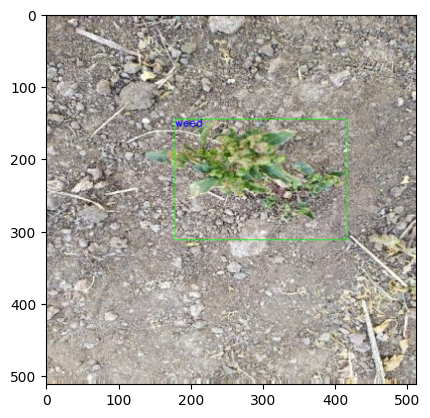

In [ ]:
train_img_show(dl_train,class_idx1)

 **Randomly checking the training set**

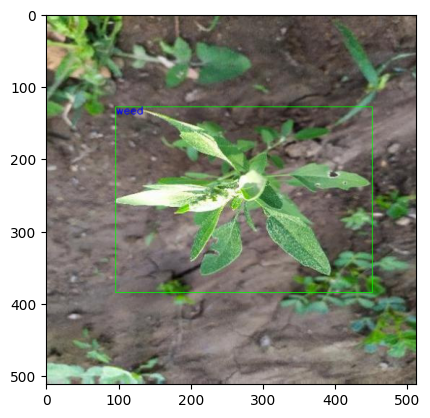

In [ ]:
train_img_show(dl_test,class_idx1)